# Poisson rSLDS 
## Behaving dataset
## Stim is as cue, system should come back to rest before lift 
## Fitting model from 50ms before cue to grab, k=2

In [120]:
import ssm
from pathlib import Path
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from real_spike.utils import *

from scipy.ndimage import gaussian_filter1d

import random
import h5py

import fastplotlib as fpl
from ipywidgets import IntSlider, VBox, Layout, Select, HBox

from PIL import Image
%matplotlib inline

In [121]:
path = f"/home/clewis/repos/realSpike/data/behavior/rb50_20250125/"

In [122]:
video_path =  Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/videos/")

# Get data

In [123]:
f = h5py.File("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/MAT_FILES/rb50_20250125_datastruct_pt3.mat", 'r')
data = f['data']
print(data.keys())

<KeysViewHDF5 ['aligned_cue_rec_time', 'aligned_laser_rec_time', 'any', 'chan_spk', 'cue', 'cue_rec_time', 'cue_trial_time', 'depth_spk', 'field_id', 'field_size', 'full_field', 'grab', 'grab_ms', 'laser', 'laser_rec_time', 'laser_trial_time', 'lift', 'lift_ms', 'lift_rec_time', 'mouth', 'mouth_ms', 'no_success', 'pattern_fill', 'pattern_id', 'pattern_xy', 'plift', 'plift_ms', 'single', 'spikes_raw_cue', 'spikes_raw_cue_extended', 'spikes_raw_laser', 'spikes_raw_lift', 'totTime', 'trial_start']>


# Plot the patterns

In [124]:
# visualize the patterns again
pattern_ids = list(np.unique(data['pattern_id'][:]))
len(pattern_ids)

30

In [125]:
from scipy.ndimage import zoom

In [126]:
reshape_size = 12

In [127]:
all_patterns = list()

for p_id in pattern_ids[3:]:
    ix = np.where(data['pattern_id'][:] == p_id)[1][0].astype(np.int32)
    pattern = np.zeros((data['pattern_xy'][0][ix].astype(np.int32), data['pattern_xy'][1][ix].astype(np.int32)))
    # use the pattern fill to set elements to one
    object_ref = f[data['pattern_fill'][ix, 0]]
    for x, y in zip(object_ref[0, :], object_ref[1, :]):
        pattern[x.astype(np.int32)-1, y.astype(np.int32)-1] = 1

    pattern = zoom(pattern, (reshape_size / pattern.shape[0], reshape_size / pattern.shape[1]), order=0)

    all_patterns.append(pattern)


In [128]:
len(all_patterns)

27

# Get single-reach trials

In [129]:
stim_idxs = np.where(data["pattern_id"][:] > 2)[1]
single_reach_idxs = np.where(data["single"][:, 0] == 1)

In [130]:
stim_idxs

array([ 16,  18,  20,  22,  23,  24,  29,  31,  32,  34,  37,  38,  40,
        42,  43,  46,  47,  48,  52,  55,  56,  60,  61,  62,  64,  67,
        68,  70,  71,  73,  76,  77,  78,  82,  83,  86,  89,  90,  92,
        94,  97,  98, 101, 103, 104, 106, 107, 108, 113, 114, 116, 118,
       121, 122, 124, 127, 128, 131, 132, 133, 150, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182,
       183, 184, 185, 186, 188, 189, 190, 191, 192, 193, 194, 195, 196,
       198, 199, 200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210,
       212, 213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224,
       225, 226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 248, 249, 250, 251, 252,
       254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264, 265, 266,
       267, 268, 269, 270, 271, 272, 273, 274, 275, 277, 278, 27

In [131]:
single_reach_idxs

(array([  2,   6,   7,   9,  10,  12,  13,  14,  15,  18,  20,  21,  23,
         26,  27,  28,  30,  32,  33,  35,  36,  37,  40,  41,  42,  44,
         45,  48,  50,  51,  53,  55,  56,  57,  60,  61,  63,  67,  68,
         70,  75,  78,  80,  83,  84,  86,  96,  97, 100, 101, 102, 103,
        106, 110, 111, 115, 118, 121, 123, 125, 128, 129, 131, 138, 142,
        145, 147, 149]),)

In [132]:
# get no laser trials
behavior_idxs = np.intersect1d(stim_idxs, single_reach_idxs)
behavior_idxs

array([ 18,  20,  23,  32,  37,  40,  42,  48,  55,  56,  60,  61,  67,
        68,  70,  78,  83,  86,  97, 101, 103, 106, 118, 121, 128, 131])

In [133]:
behavior_idxs.shape

(26,)

## Get relevant time information

In [134]:
cue_times = data["aligned_cue_rec_time"][behavior_idxs, :]
lift_times = data["lift_ms"][behavior_idxs, :]
grab_times = data["mouth_ms"][behavior_idxs, :]
(cue_times.shape, lift_times.shape, grab_times.shape)

((26, 1), (26, 1), (26, 1))

## Get the AP.bin file

In [135]:
file_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.bin")
meta_path = Path("/home/clewis/wasabi/reaganbullins2/ProjectionProject/rb50/20250125/rb50_20250125_g0/rb50_20250125_g0_t0.imec0.ap.meta")

In [136]:
meta_data = get_meta(meta_path)

In [137]:
ap_data = get_sample_data(file_path, meta_data)
ap_data.shape

(385, 164723792)

## Get conversion params

In [138]:
vmax = float(meta_data["imAiRangeMax"])
# get Imax
imax = float(meta_data["imMaxInt"])
# get gain
gain = float(meta_data['imroTbl'].split(sep=')')[1].split(sep=' ')[3])

(vmax, imax, gain)

(0.6, 512.0, 500.0)

# Get the model data

In [139]:
def get_trials(idxs, bin_size):
    
    model_data = list()
    
    for i, j in tqdm(enumerate(idxs)):
        c = data["aligned_cue_rec_time"][j, 0] 
        g = data["grab_ms"][j, 0]
        # 50 ms before cue
        cue_time = int((c - 50) / 1_000 * 30_000)

        # end at 5m after grab 
        end_behavior = int((c + g) / 1_000 * 30_000)

        
        trial = ap_data[:150, cue_time:end_behavior]
    
        # convert to microvolts
        conv_data = 1e6 * trial / vmax / imax / gain
        # high pass filter 
        filt_data = butter_filter(conv_data, 1_000, 30_000)

        # get 1 second before the median 
        m_start = cue_time - (30 * 1000)
        # convert to microvolts, high pass filter
        trial_median = ap_data[:150, m_start:cue_time]
        trial_median = 1e6 * trial_median / vmax / imax / gain
        trial_median = butter_filter(trial_median, 1_000, 30_000)
        
        # calculate the median
        median = np.median(trial_median, axis=1)

        # get spike times
        spike_ixs, counts = get_spike_events(filt_data, median)
        
        a = np.zeros((filt_data.shape[0], filt_data.shape[1]))
    
        for i, sc in enumerate(spike_ixs):
            a[i, sc] = 1
    
        b = bin_size * 30 # 30ms per bin
        binned_spikes = bin_spikes(a, b)

        model_data.append(np.asarray(binned_spikes.T, dtype=int))

    return model_data

In [140]:
bin_size = 5

In [141]:
model_data = get_trials(behavior_idxs, bin_size)

0it [00:00, ?it/s]

In [142]:
model_data[0].shape

(92, 150)

In [143]:
# taking 50ms before cue, need to shift
cue = int(50 / bin_size)

lift = int(data["lift_ms"][18, 0] / bin_size) + cue

grab = int(data["grab_ms"][18, 0] / bin_size) + cue - 1
(lift, grab)

(72, 91)

### Sanity check the time points

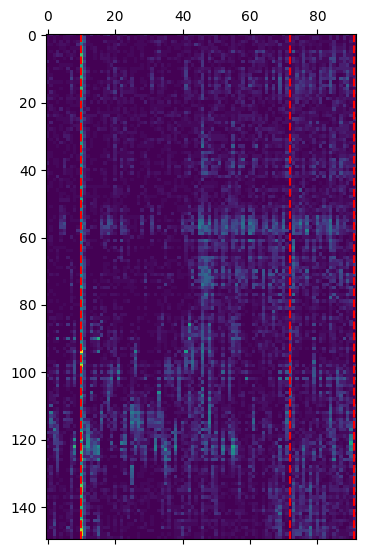

In [144]:
plt.matshow(model_data[0].T)
plt.axvline(cue, c="red", linestyle="--")
plt.axvline(lift, c="red", linestyle="--")
plt.axvline(grab, c="red", linestyle="--")

# Design the input matrix

In [145]:
p_ids = np.unique(data["pattern_id"][0, behavior_idxs])

p_ids

array([14., 17., 20.])

## Get colors for plotting

In [146]:
c = {
    14: "blue",
    17: "orange",
    20: "green"
}

In [147]:
len(c)

3

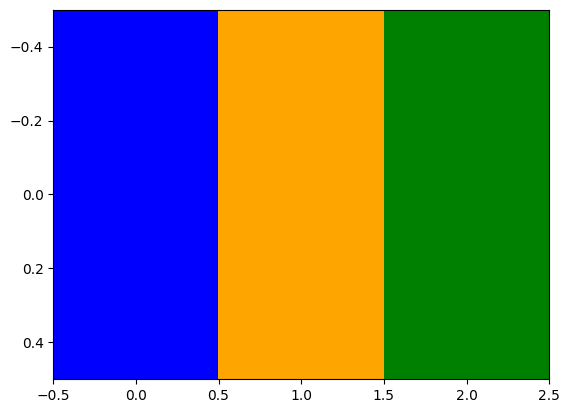

In [148]:
from matplotlib.colors import ListedColormap

cmap = ListedColormap(c.values())

plt.imshow(np.arange(len(c)).reshape(1,-1), aspect="auto", cmap=cmap)

# Create encodings 

In [149]:
import math

In [150]:
inputs = list()
colors = list()
for i, d in zip(stim_idxs, model_data):
    # get the pattern id 
    p_id = int(data["pattern_id"][0][i]) - 3

    colors.append(c[p_id + 3])

    encoding = all_patterns[p_id].ravel() 

    # stack the encoding for every timepoint (each bin)
    nput = np.zeros((d.shape[0], reshape_size**2))

    for z in range(math.ceil(5 / bin_size)):
        nput[int(50 / bin_size) + z] = encoding

    inputs.append(nput)

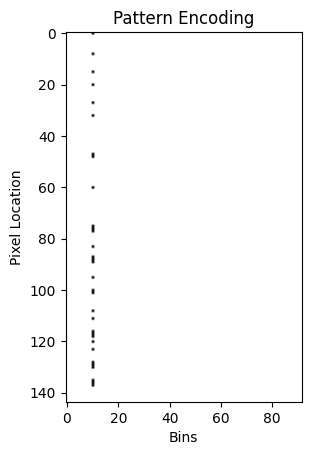

In [151]:
plt.imshow(inputs[0].T, cmap="binary")
plt.title("Pattern Encoding")
plt.xlabel("Bins")
plt.ylabel("Pixel Location")
plt.show()

# Fit the model

In [152]:
state_dim = 3
obs_dim = model_data[0].shape[1] 

plds = ssm.SLDS(N=obs_dim, 
                K=2, 
                D=state_dim, 
                M=144, 
                emissions="poisson", 
                emission_kwargs=dict(link="softplus"),
                dynamics="diagonal_gaussian",
                transitions="recurrent"
               )

elbos, q = plds.fit(model_data, inputs=inputs, method="laplace_em", num_iters=5)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [153]:
state_means = q.mean_continuous_states
len(state_means)

26

# Visualize a trial

In [96]:
trial_no = 0

In [97]:
behavior_idxs[0]

np.int64(18)

In [98]:
i = behavior_idxs[trial_no]
# get video 
front_video = LazyVideo(video_path.joinpath(f"rb50_20250125_front_v0{i + 1}.avi"))
side_video = LazyVideo(video_path.joinpath(f"rb50_20250125_side_v0{i + 1}.avi"))
(front_video.shape, side_video.shape)

((2498, 290, 448), (2498, 290, 448))

In [99]:
fig = fpl.Figure(shape=(2,2), 
                 size=(800, 800), 
                 names=["front", "side", "binned_spikes", "z_t"], 
               #  cameras=["2d", "2d", "2d", "3d"]
                )

fig["front"].axes.visible = False
fig["front"].controller.enabled = False
fig["side"].axes.visible = False
fig["side"].controller.enabled = False
fig["binned_spikes"].axes.visible = False
fig["binned_spikes"].camera.maintain_aspect = False
fig["binned_spikes"].controller.enabled = False

fig["z_t"].camera = "3d"
fig["z_t"].controller = "fly"

RFBOutputContext()

In [100]:
front_graphic = fig["front"].add_image(front_video[0])
side_graphic = fig["side"].add_image(side_video[0])
heatmap = fig["binned_spikes"].add_image(model_data[trial_no].T, cmap="viridis")
ls = heatmap.add_linear_selector()
z_smooth = gaussian_filter1d(state_means[trial_no], 6, axis=0)
z_graphic = fig["z_t"].add_line(z_smooth)


In [101]:
cue = int(50 / bin_size)

lift = int(data["lift_ms"][18, 0] / bin_size) + cue

grab = int(data["grab_ms"][18, 0] / bin_size) + cue - 1
(lift, grab)

(72, 91)

In [102]:
# mark stim 
z_stim = fig["z_t"].add_scatter(z_smooth[cue].reshape(1,3), sizes=15, colors="blue")
# mark lift 
z_lift = fig["z_t"].add_scatter(z_smooth[lift].reshape(1,3), sizes=15, colors="green")
# mark grab 
z_grab = fig["z_t"].add_scatter(z_smooth[grab].reshape(1,3), sizes=15, colors="yellow")

# add tracer
z_point = fig["z_t"].add_scatter(z_smooth[0].reshape(1,3), sizes=15, colors="red")

In [103]:
slider = IntSlider(value=0, min=0, max=model_data[trial_no].shape[0]-1, layout=Layout(width="50%"))

In [107]:
selection = Select(
    options=list(behavior_idxs),
    value=behavior_idxs[0],
    # rows=10,
    description='Trial:',
    disabled=False,
    layout=Layout(width="25%", height="50%")
)

In [108]:
def update(ev):
    global cue
    global front_video
    global side_video
    t = ev["new"] 

    # update linear selector in heatmap 
    ls.selection = t 

    # update scatter point selection 
    z_point.data = z_graphic.data[t].reshape(1,3)

    if t >= cue: 
        # if right at the end near grab, need to add 1
        if t == z_graphic.data.value.shape[0] - 1:
            t += 1
        # update the video 
        s = ((t+1) * 5) + 950
        s = math.ceil(s / 2)
        front_graphic.data = front_video[s]
        side_graphic.data = side_video[s]

    # output save for ffmpeg
    d = fig.canvas.snapshot().data
    pil_image = Image.fromarray(d, 'RGBA')
    pil_image.save(f'/home/clewis/Desktop/behavior/{t}.png')
    
        

In [109]:
def trial_change(ev):
    global heatmap
    global ls
    global z_graphic
    global z_stim 
    global z_lift 
    global z_grab
    global z_point
    global front_video
    global side_video
    
    i = ev["new"] 
    trial_no = np.where(behavior_idxs == i)[0][0]

    if i <= 8:
        i = f"00{i+1}"
    elif i <= 98:
        i = f"0{i+1}"
    else:
        i = f"{i+1}"

    front_video = LazyVideo(video_path.joinpath(f"rb50_20250125_front_v{i}.avi"))
    side_video = LazyVideo(video_path.joinpath(f"rb50_20250125_side_v{i}.avi"))

    t = 0
    slider.value = t
    slider.max = model_data[trial_no].shape[0]-1
    front_graphic.data = front_video[t] 
    side_graphic.data = side_video[t] 

    fig["binned_spikes"].remove_graphic(heatmap)
    fig["binned_spikes"].remove_graphic(ls)
    
    heatmap = fig["binned_spikes"].add_image(model_data[trial_no].T, cmap="viridis")
    ls = heatmap.add_linear_selector()
    fig["binned_spikes"].auto_scale()

    z_smooth = gaussian_filter1d(state_means[trial_no], 6, axis=0)

    fig["z_t"].remove_graphic(z_graphic)
    z_graphic = fig["z_t"].add_line(z_smooth)
    fig["z_t"].auto_scale()

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][ev["new"], 0] / bin_size) + cue

    grab = int(data["grab_ms"][ev["new"], 0] / bin_size) + cue - 1

    z_stim.data = z_smooth[cue].reshape(1,3)
    # mark lift 
    z_lift.data = z_smooth[lift].reshape(1,3)
    # mark grab 
    z_grab.data = z_smooth[grab].reshape(1,3)
    
    # add tracer
    z_point.data = z_smooth[0].reshape(1,3)

In [110]:
slider.observe(update, "value")

In [111]:
selection.observe(trial_change, "value")

In [112]:
VBox([HBox([fig.show(), selection]), slider])

# Plot all trajectories together

In [ ]:
# plot all trajectories together in single plot

In [118]:
figure2 = fpl.Figure(shape=(1,1), names=["points"], cameras="3d")

for i, d in enumerate(model_data):
    trial_no = behavior_idxs[i]
    z_smooth = gaussian_filter1d(state_means[i], 6, axis=0)

    cue = int(50 / bin_size)

    lift = int(data["lift_ms"][trial_no, 0] / bin_size) + cue

    grab = int(data["grab_ms"][trial_no, 0] / bin_size) + cue - 1

    figure2["points"].add_scatter(z_smooth[cue].reshape(1,3), sizes=15, colors="blue")
    # mark lift 
    figure2["points"].add_scatter(z_smooth[lift].reshape(1,3), sizes=15, colors="green")
    # mark grab 
    figure2["points"].add_scatter(z_smooth[grab].reshape(1,3), sizes=15, colors="yellow")

RFBOutputContext()

JupyterRenderCanvas(css_height='300.0px', css_width='500.0px')
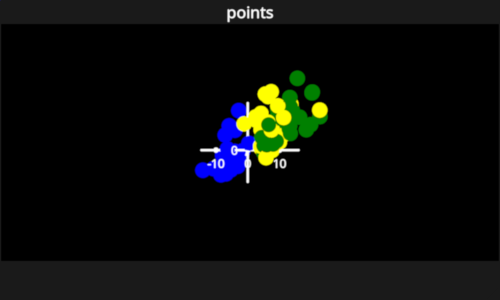

In [119]:
figure2.show()

In [113]:
colors

['green',
 'orange',
 'blue',
 'blue',
 'green',
 'orange',
 'orange',
 'blue',
 'green',
 'blue',
 'orange',
 'green',
 'orange',
 'blue',
 'green',
 'blue',
 'orange',
 'green',
 'green',
 'blue',
 'orange',
 'blue',
 'orange',
 'green',
 'orange',
 'blue']